In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup the notebook's environment
import lalsimulation as lalsim
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase, gc, gwylmo_cpclean
from numpy.linalg import norm
from scipy.optimize import curve_fit,minimize,fmin

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"
(xcp.core)>> According to the global config, the XCP package is configured to model the [(2, 2), (3, 3)] coprecessing moment multipole moment(s)


In [2]:
# a = scsearch(keyword='q2_a10_a28_ph0_th30',catalog=calibration_catalog,verbose=True)[0]
a = scsearch(keyword='q2_a10_a28_ph0_th30',catalog=calibration_catalog,verbose=True)[0]

(scsearch)>> Found catalog (=...) keyword.
(scsearch)>> Found keyword (=q4a08t60) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
(scsearch)>> ## Found 1 possibly degenerate simulations:
(scsearch)>> [0001][pnr-catalog] q4: 1chi0.80-p-q4.00	(q4a08t60dPm3dRm250_T_96_384)



In [3]:
# Define loading parameters 
lmax = 4
pad = 1000
clean = True
dt = 0.5
kind = 'psi4'

In [4]:
y = gwylm(a,lmax=lmax,dt=dt,pad=pad,clean=clean,verbose=False)

(romline!)>> N is 2, but it must be less than or equal to 3. We have set N=3. This course is often desired in cases where N=2 is naively given.


In [5]:
# Manage frames using dict defined below
frame = {}
frame['raw'] = y

# Put in initial J frame
frame['init-j'] = y.__calc_initial_j_frame__()

(__rotate_frame_at_all_times__)>> TIME DOMAIN rotation specified
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.


In [6]:
# # Symmetrize the psi4 time domain coprecessing frame waveform, and return to the init-j frame
# frame['star-init-j'] = gwylmo_cpclean( frame['init-j'], cp_domain='td' )

# NOTE that although the angles model uses the j(t) frame, 
# we do NOT use this here as the coprecessing frame is uniquely 
# defined and the j(t) frame only adds problematic noise

alert('Computing coprecessing frames',header=True)
# Solve optimal emission problem for l subsets
subframe       = {}
cp_subframe_fd = {}
# cp_subframe_td = {}
subangles      = {}
# subangles_td   = {}
for ll in [2,3]:#range(2,lmax+1):

    #
    mm = ll

    #
    alert('Calculating coprecessing frame for l=%i subset ...'%ll)

    # Select only multipoles with l = ll
    raw_subframe = frame['init-j'].selectlm( [(ll,m_) for m_ in range(-ll,ll+1)] )

    # ** Go to coprecessing frame, symmetrize, revert back to original frame **
    subframe[ll] = gwylmo_cpclean( raw_subframe )

    #
    subframe[ll].scrub(apply=True)

    # Solve the optimal emission problem and rotate multipoles
    cp_subframe_fd[ll] =  subframe[ll].__calc_coprecessing_frame__( kind=kind, 
                                                                 transform_domain='fd' )
    

    # Store angles for this ll
    foo = cp_subframe_fd[ll].previous_radiation_axis_info
    subangles[ll] = [ foo.radiation_axis[k] for k in ('fd_alpha','fd_beta','fd_gamma') ]
    # bar = cp_subframe_td[ll].previous_radiation_axis_info
    # subangles_td[ll] = [ foo.radiation_axis[k] for k in ('td_alpha','td_beta','td_gamma') ]

    #
    gwfo_psi4 = cp_subframe_fd[ll]
    
    #
    break
#     # **
#     alert('Saving diagnostic plot for l=m=%i ...'%ll)
#     fig, ax, output_data, format_tags = collect_nr_data_plotting_helper( ll, cp_subframe_fd[ll], subangles[ll], unwrap_dphi=False )
#     #
#     png_file_path = data_dir+'%s_l%im%i.png'%(cp_subframe_fd[ll].simname,ll,mm)
#     savefig( png_file_path, pad_inches=0 )
#     alert('Diagnostic plot saved to "%s"'%yellow(png_file_path))
#     close('all')

#     #
#     txt_file_path = data_dir+'%s_l%im%i.txt'%(cp_subframe_fd[ll].simname,ll,mm)
#     heaber = header = ',        '.join(format_tags)
#     alert('Saving related data to "%s"'%yellow(txt_file_path))
#     savetxt( txt_file_path, output_data, header=header )


# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(notebook)>> Computing coprecessing frames
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(notebook)>> Calculating coprecessing frame for l=2 subset ...
(gwylmo_cpclean)>> Using the Time Domain coprecessing frame for cleaning.
(__rotate_frame_at_all_times__)>> TIME DOMAIN rotation specified
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.
(__calc_coprecessing_frame__)>> We will use psi4 to compute the co-precessing frame.
(__calc_coprecessing_frame__)>> Transforming to the coprecessing frame using TD angles.
(__calc_radiated_linear_momentum__!)>> The current objects max ell value is 2, but we recommend a value of at least 4 for accurate determination of radiate

(0.01, 0.1)

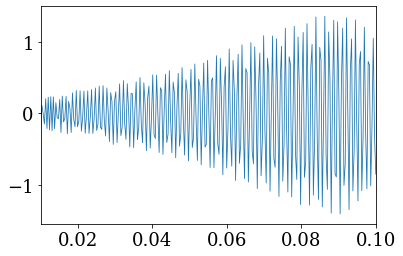

In [9]:
plot(cp_subframe_fd[ll].f,cp_subframe_fd[ll][2,2]['psi4'].fd_y.real)
xlim(0.01,0.1)

In [97]:
s_gwfo_psi4 = gwfo_psi4.__smooth__(30)

(smooth_wfarr)>> 0.8998454398160686
(smooth_wfarr)>> -2.3474829382494846
(smooth_wfarr)>> 2.4305541111457005
(smooth_wfarr)>> -2.7565736439261186
(smooth_wfarr)>> -0.351417128999103
(smooth_wfarr)>> 3.2490241405436198
(smooth_wfarr)>> -0.5750891879554294
(smooth_wfarr)>> -1.7067164962180352
(smooth_wfarr)>> -0.2932241698692058
(smooth_wfarr)>> -1.317151246534682
(smooth_wfarr)>> -1.2996729507455855
(smooth_wfarr)>> -3.379382029287945
(smooth_wfarr)>> -0.9019549100057911
(smooth_wfarr)>> 1.853812220759292
(smooth_wfarr)>> -2.850121291890597


In [98]:
l,m = 2,2
f = gwfo_psi4.f
dphi_1 = gwfo_psi4[l,m]['psi4'].fd_dphi
dphi_2 = s_gwfo_psi4[l,m]['psi4'].fd_dphi

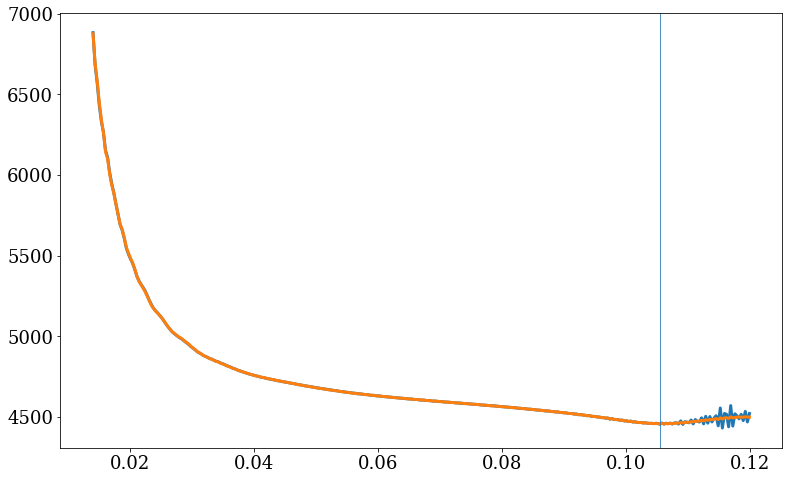

In [99]:

#
figure( figsize=2*figaspect(0.6182) )

#
k = (f>0.014*l/2) & (f<0.12*l/2)
plot( f[k], dphi_1[k],lw=3)
plot( f[k], dphi_2[k],lw=3)
# plot( f[k], smooth(dphi_1[k],width=20).answer, color='tab:red',lw=2)
# plot( f[k], smooth(dphi_2[k],width=20).answer, color='k', ls=':',lw=2)

axvline( gwfo_psi4[l,m]['psi4'].qnm_prograde_fring )


([<AxesSubplot:ylabel='$rM\\psi_{3-3}$'>,
  <AxesSubplot:ylabel='$\\phi = \\mathrm{arg}(rM\\psi_{3-3})$'>,
  <AxesSubplot:ylabel='$\\mathrm{d}{\\phi}/\\mathrm{d}t$'>,
  <AxesSubplot:xlabel='$t$', ylabel='$\\mathrm{d}^2{\\phi}/\\mathrm{d}t^2$'>],
 <Figure size 1152x1382.4 with 4 Axes>)

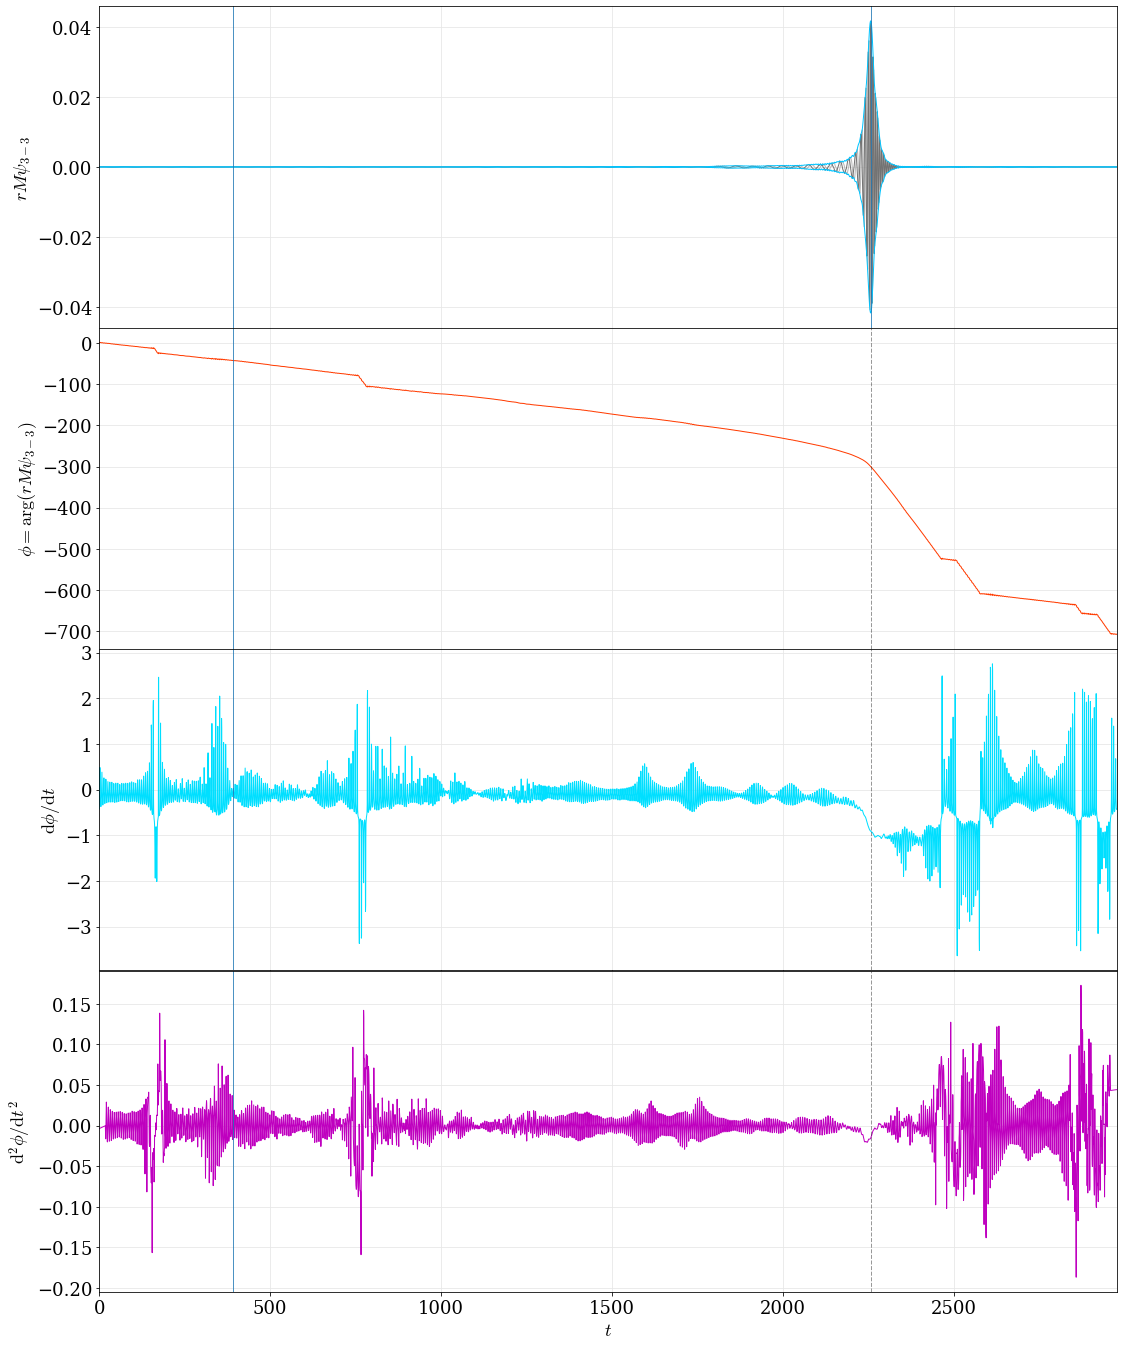

In [75]:
cp_subframe_fd[ll][3,-3]['psi4'].plot(sizescale=2)

([<AxesSubplot:ylabel='$rM\\psi_{33}$'>,
  <AxesSubplot:ylabel='$\\phi = \\mathrm{arg}(rM\\psi_{33})$'>,
  <AxesSubplot:ylabel='$\\mathrm{d}{\\phi}/\\mathrm{d}t$'>,
  <AxesSubplot:xlabel='$t$', ylabel='$\\mathrm{d}^2{\\phi}/\\mathrm{d}t^2$'>],
 <Figure size 1152x1382.4 with 4 Axes>)

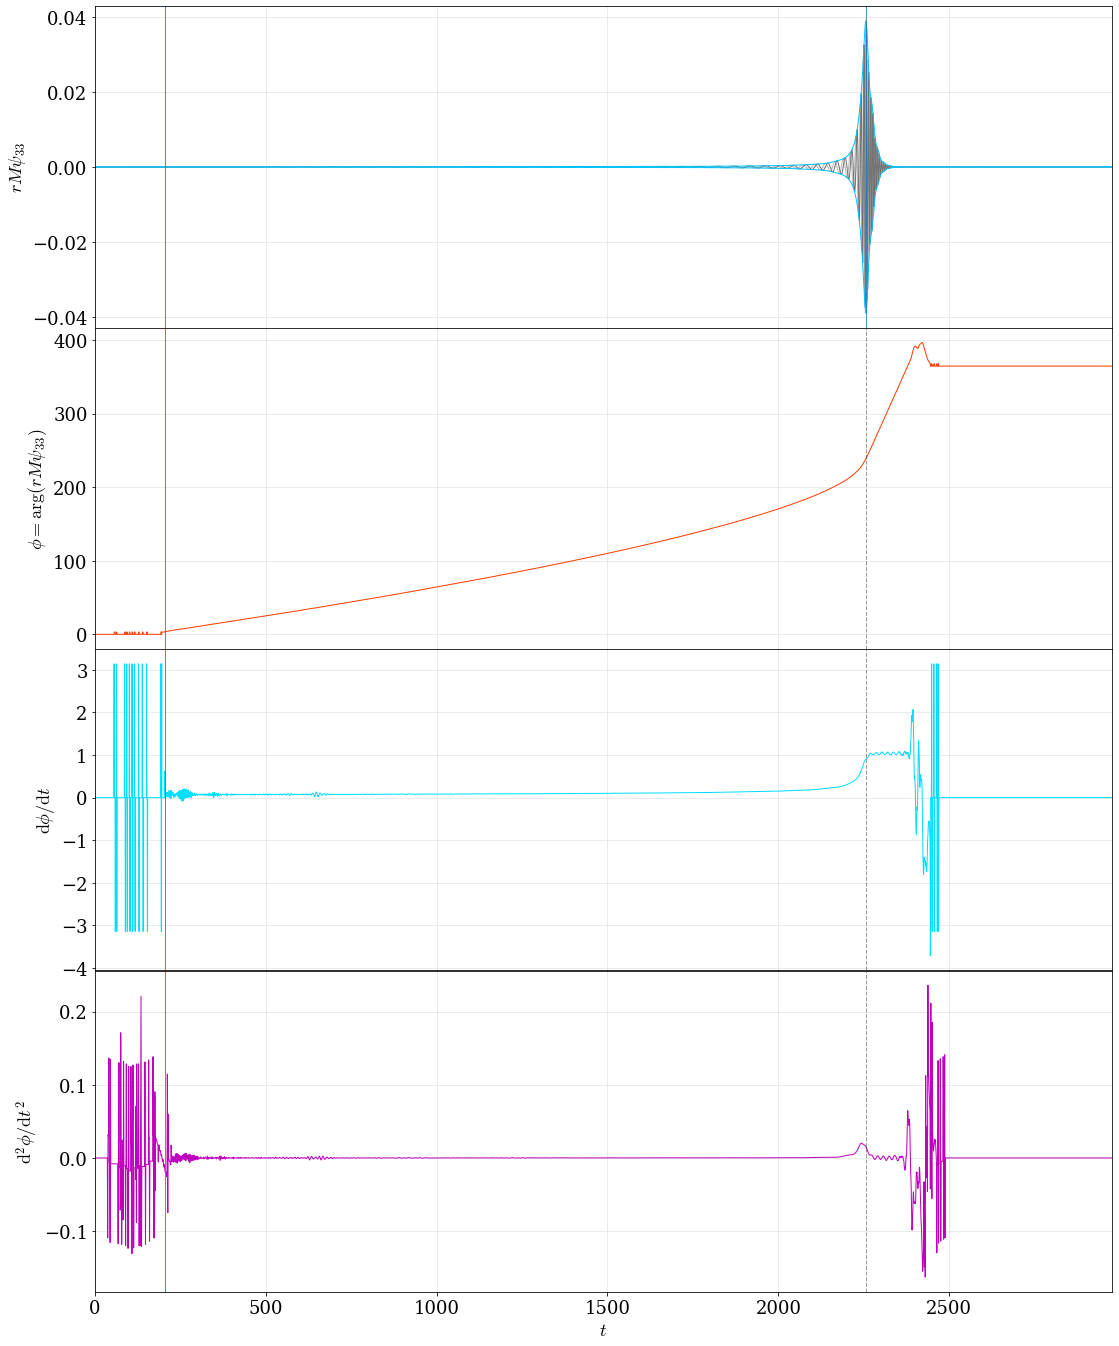

In [71]:
frame['raw'][3,3]['psi4'].plot(sizescale=2)